<a href="https://colab.research.google.com/github/mibeaum/ML/blob/master/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time series classification**



Load Python modules

In [51]:
import numpy as np  # Arrays, matrices and functions on them. Required by Pandas, below
import pandas as pd # A data analysis library
from sklearn.model_selection import train_test_split # scikit-learn, machine learning tools
import matplotlib.pyplot as plt # A plotting library
import seaborn as sns # Built on matplotlib, facilitates aesthetically pleasing plots
from sklearn import cluster
import datetime

import tensorflow as tf # Fast numerical computation for machine learning, computations on GPU or CPU
import tensorflow.keras as keras # High-level interface to TensorFlow, making it easier to create neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

# General settings
sns.set_style('whitegrid') # Plots will have a white grid
# Variables that will help us work with the classes
class_names = ['workstation', 'server']
class_colors = ['darkorange', 'steelblue']


Functions

In [120]:
def load_data(filename):
    ''' Load the data from a file in a GitHub repo '''
    url_root = 'https://raw.githubusercontent.com/mibeaum/ML/master'
    url = url_root+'/'+filename
    mydateparser = lambda x: ( 
       pd.to_datetime(x, format="%d/%m/%Y%H:%M:%S").strftime("%H")
    )    
    df = pd.read_csv(url, sep=',', header=0, usecols = ["server", "dateTime", "internalPacketIdentifier"], parse_dates=['dateTime'], date_parser=mydateparser) # Use Pandas to load the data into a Pandas DataFrame
    df["dateTime"] = pd.to_numeric(df["dateTime"])
    df.sort_values(by=['dateTime'])
    print('Loaded from', url)
    data = df.values # Convert from a Pandas DataFrame to a numpy array
    print('The shape of data is', df.values)
    print('')
    return df

def plot_data_samples(df, labels):
    ''' Plot the time series data relating to the input list of sample numbers '''
    plt.scatter(df['dateTime'], df['server'])

    ylabels = [x for x in df['server']]
    plt.yticks(df['server'], ylabels)

    print('')
    #plt.set ylim([00.00, 23.59])
    plt.title('workstation (class 0): server (class 1)')
    plt.ylabel('Server')
    plt.xlabel('Time')    

Load the data

In [121]:
filename = 'data.csv'
df = load_data(filename) 
data_log = df.values # Convert from a Pandas DataFrame to a numpy array
print('These are the first 7 rows of data_log:\n', data_log[0:7], '\n')

Loaded from https://raw.githubusercontent.com/mibeaum/ML/master/data.csv
The shape of data is [[0 8 '0000026335FA1560']
 [0 9 '0000026335FA1560']
 [1 19 '0000026335C83DB0']
 [1 20 '0000026335C83DB0']
 [0 10 '0000026338FC9920']
 [0 11 '0000026338FC9920']
 [0 11 '00000263351894F0']
 [0 12 '00000263351894F0']
 [1 20 '000002633810C960']
 [1 20 '000002633810C960']
 [0 13 '0000026335FA1560']
 [0 13 '0000026335FA1560']
 [1 21 '0000026335C83DB0']
 [1 22 '0000026335C83DB0']
 [0 13 '0000026338FC9920']
 [0 13 '0000026338FC9920']
 [0 14 '00000263351894F0']
 [0 14 '00000263351894F0']
 [1 19 '000002633810C960']
 [1 21 '000002633810C960']
 [0 14 '0000026335FA1560']
 [0 14 '0000026335FA1560']
 [1 20 '0000026335C83DB0']
 [1 23 '0000026335C83DB0']
 [0 14 '0000026338FC9920']
 [0 15 '0000026338FC9920']
 [0 15 '00000263351894F0']
 [0 16 '00000263351894F0']
 [1 1 '000002633810C960']
 [1 3 '000002633810C960']
 [0 8 '0000026335FA1560']
 [0 9 '0000026335FA1560']
 [1 3 '0000026335C83DB0']
 [1 0 '0000026335C83DB

Process the data

In [122]:
labels = data_log[:,0].astype(int)
data = data_log[:,1:]
print('The shape of the labels vector is', labels.shape)
print('The shape of the data matrix is', data.shape)
print('These are the first 7 elements of labels vector:\n', labels[0:7], '\n')
print('These are the first 7 rows of data matrix:\n', data[0:7], '\n')



The shape of the labels vector is (42,)
The shape of the data matrix is (42, 2)
These are the first 7 elements of labels vector:
 [0 0 1 1 0 0 0] 

These are the first 7 rows of data matrix:
 [[8 '0000026335FA1560']
 [9 '0000026335FA1560']
 [19 '0000026335C83DB0']
 [20 '0000026335C83DB0']
 [10 '0000026338FC9920']
 [11 '0000026338FC9920']
 [11 '00000263351894F0']] 



Plot the data

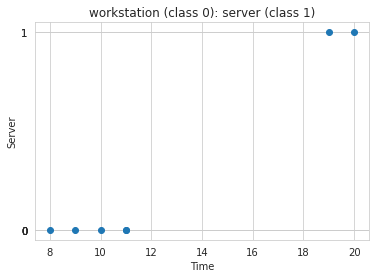

In [123]:
plot_data_samples(df[0:7], labels) 

Split the data set

In [68]:
test_size = 21

# Use the train_test_split from the scikit-learn (sklearn) module
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=test_size, random_state=21, stratify=labels)

print('The shape of data_train is', data_train.shape)
print('The shape of data_test is', data_test.shape)
print('Train data:')
print('Number of samples of class 0', (labels_dev == 0).sum())
print('Number of samples of class 1', (labels_dev == 1).sum())
print('Test data:')
print('Number of samples of class 0', (labels_finaltest == 0).sum())
print('Number of samples of class 1', (labels_finaltest == 1).sum())


The shape of data_train is (21, 2)
The shape of data_test is (21, 2)
Train data:
Number of samples of class 0 13
Number of samples of class 1 8
Test data:
Number of samples of class 0 12
Number of samples of class 1 9


Create a multilayer perceptron (MLP) model

In [69]:
# The size of the input vector
input_dim = data_train.shape[1]

def build_model(print_summary=False):
    ''' Return a model with randomly initialised weights '''
    model = Sequential([
        Dense(8, input_dim=input_dim, activation='relu', name='Layer1'), 
        Dense(4, activation='relu', name='Layer2'), 
        Dense(1, activation='sigmoid', name='OutputLayer')
    ])

    optimizer = keras.optimizers.Adam() 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if print_summary:
        print(model.summary())
    return model


model = build_model(True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Dense)               (None, 8)                 24        
_________________________________________________________________
Layer2 (Dense)               (None, 4)                 36        
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 5         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None


Test the untrained MLP

In [70]:
result = model.evaluate(data_test, labels_test, batch_size=5)
print('Pre-training, validation accuracy is', result[1])

ValueError: ignored